# Preamable

> Download and extract data for notebook execution.

The cell below prepares the Google Colab environment for execution. It will download our dataset and the FLIM-Weights, which we will use in the following notebook (2_flim_classification.ipynb).

In [ ]:
import requests
from io import BytesIO
from zipfile import ZipFile
import os

def download_and_extract_zip(url, extract_path):
  response = requests.get(url, stream=True)
  response.raise_for_status()  # Raise an exception for bad status codes

  with ZipFile(BytesIO(response.content)) as zip_file:
    zip_file.extractall(extract_path)

if not os.path.exists("./citrus_leaves"):
  google_drive_url = "https://drive.usercontent.google.com/download?id=1qDDYTSKisYusWAkSbYHHljzXET2r66Tu&export=download&authuser=2&confirm=yes"
  download_and_extract_zip(google_drive_url, "./")
else:
  print("[INFO] Data already downloaded")

[INFO] Data already downloaded


# Classification of Citrus Diseases

> This notebook covers the necessary steps to experiment with a Neural Network towards a classification problem. We will focus on Citrus leaf diseases, investigating a plain neural architecture to convert input images to a high-dimensional space. In this high-dimensional space, our representation is expected to be sparse and separable into different classes.

We will approach the following:

1. Split our data into training and testing;
2. Configure a dataset (With augmentations);
3. Configure our dataset as a data loader to provide data ingestion during the training phase;
4. Define a Model (Convolutional + Fully Connected);
5. Define a training loop, saving our best model;
6. Run a training experiment;
7. Define a testing loop;
9. Test our best model.

## 1. Split our data into train and test data:

Let us first define our dataset.

We will explore the citrus leaf diseases, where we want to classify the disease given a leaf image.

The cell below imports the necessary libraries.

In [ ]:
# Necessary libraries
from pathlib import Path, PosixPath
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import torch
from random import shuffle

First, we need to define the path to our dataset. We are using the Citrus Disease dataset (images have a shape of 256x256 pixels with three channels). To run our experiments, we need to use either a GPU ("cuda") or a CPU ("cpu"); for such, we set the DEVICE variable.

Also, we will set up a folder to save our outputs (models and predictions).

In [ ]:
DATA_PATH = Path("citrus_leaves/orig_aug")
MODEL_FOLDER = Path("citrus_leaves/models/sample_model")
# DEVICE = "cpu" # if you do not have a GPU
DEVICE = "cuda"

If we look at the image folder, we will see five folders. One for each of the following classes:

1. Blackspot
2. Canker
3. Greening
4. Healthy
5. Melanose

Each folder will hold 50 images for the respective class.

Also, as we have five classes (in this example), we set weights for each class to indicate which classes are more difficult to classify correctly.

> IMPORTANT: The model can struggle to solve some classes. A possible solution is to set weights during loss computation (i.e., more challenging classes will have higher weights). Our problem has five classes, so we need a `five-weight vector`. **If we face a problem with more classes, we modify the weight vector accordingly.**

Here, we also set the number of training epochs and our learning rate.

In [ ]:
CLASSES_LIST = os.listdir(DATA_PATH)
CLASSES_LIST.sort()
N_CLASSES = len(CLASSES_LIST)
print(f"N Classes: {N_CLASSES}")
print(f"Class folders:\n{CLASSES_LIST}")

# Training parameters
WEIGHT_VECTOR = [1, 1, 1.5, 1, 1]
EPOCHS=150
LR=1e-5

N Classes: 5
Class folders:
['1_blackspot', '2_canker', '3_greening', '4_healthy', '5_melanose']


Now, we will get the paths for all images, following a 70%-30% split for training and testing for each class. The cell below implements this procedure:

In [ ]:
train_image_paths = []
test_image_paths = []

for class_folder in CLASSES_LIST:
    folder_path = DATA_PATH / Path(class_folder)
    images = os.listdir(folder_path)
    images.sort()
    n_train_images = int(0.7 * len(images))

    train_images = images[:n_train_images]
    test_images = images[n_train_images:]

    # Append image paths
    for train_image in train_images:
        train_image_paths.append(folder_path / Path(train_image))
    for test_image in test_images:
        test_image_paths.append(folder_path / Path(test_image))

In [ ]:
# Uncomment the cell belows to validate the splits
#print(train_image_paths)
#print(test_image_paths)

Now, we have successfully split 175 training images and 75 testing images.

In [ ]:
print("Training images: ", len(train_image_paths))
print("Testing images: ", len(test_image_paths))

Training images:  175
Testing images:  75


Our next step is to implement the methods to feed those images during the training of our classifier.

## 2. Configure a dataset (With augmentations)

Now, we need to define the Dataset Class. It will:

1. Enable training and testing using our data splits (i.e., image paths).
2. Use augmentations. As we see in segmentation notebooks, sometimes a model performs well in training but poorly in unseen data. Hence, our model cannot generalize a behavior known as overfitting. A good practice to avoid overfitting is using augmentations on the fly. Using augmentations enables us to modify images in different forms at each epoch.

We start by importing the necessary libraries.

In [ ]:
from torch.utils.data import Dataset
from typing import List, Union
from torchvision import transforms, models
from torchvision.transforms import InterpolationMode
import numpy as np
from torch.utils.data import DataLoader
from PIL import ImageOps
import random

Then, we define our dataset class:

In [ ]:
class ClassificationDataset(Dataset):
    def __init__(
        self,
        images_paths: List[PosixPath], # Path to images
        augmentation: False # Augment or not input images
    ) -> None:
        self.images_path = images_paths

        # Sets torch seed to guarantee Reproducibility
        self.random_seed = 7
        torch.manual_seed(self.random_seed)
        torch.cuda.manual_seed(self.random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        if augmentation == True:
            self.transforms = transforms.Compose([
                transforms.RandomAffine(
                    degrees=10, translate=(0.05,0.10), scale=(0.9,1.1), shear=(-2,2),
                    interpolation=transforms.InterpolationMode.BILINEAR,
                    fill=0
                ),
                transforms.RandomHorizontalFlip(),
                transforms.RandomVerticalFlip(),
                transforms.ToTensor()
            ])
        else:
            self.transforms = transforms.ToTensor()

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        image_path = self.images_path[idx]
        class_folder = os.path.dirname(image_path).split("/")[-1]
        label_ = int(class_folder.split("_")[0])
        label_one_hot = np.zeros(5)
        label_one_hot[label_ - 1] = 1

        random.seed(self.random_seed)
        image = self.transforms(Image.open(image_path))
        label = torch.Tensor(label_one_hot)

        return image, label

Now, let us create objects representing our datasets.

In [ ]:
train_dataset = ClassificationDataset(
    images_paths=train_image_paths,
    augmentation=True
)
# Augmentation is not necessary for our test data
test_dataset = ClassificationDataset(
    images_paths=test_image_paths,
    augmentation=False
)

Explore the datasets by visualizing images. The ```__getitem__``` ' method enables us to get any image, read it, and display it (augmented or not).

> Play with the idx parameter.

In [ ]:
def vizualize_item(dataset, idx):
    image, label = dataset.__getitem__(idx=idx)
    image = image.transpose(0, 2)
    image = image.detach().cpu().numpy()
    image = (image * 255).astype(np.uint8)
    label = label.detach().cpu().numpy()
    label = np.argmax(label)
    title = CLASSES_LIST[label]

    plt.imshow(image)
    plt.title(title)

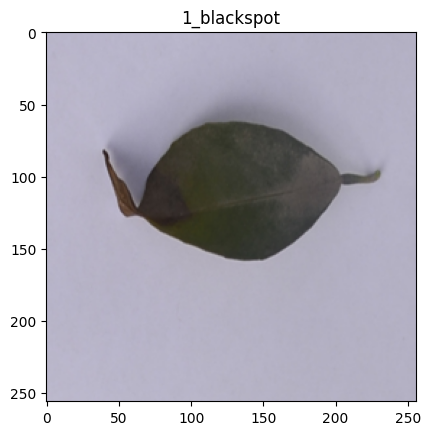

In [ ]:
vizualize_item(test_dataset, 10)

If we try to visualize the same image for training data, the data will be displayed in different forms each time (because of augmentation).

For test data, images are always the same.

## 3. Configure our dataset as a dataloader

Finally, through PyTorch data loader ([`torch.utils.data.DataLoader`](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader)), we configure our dataset as a data loader by using:

- A Dataset (Our Train and Test datasets);
- A batch size (Number of images used to update the model's parameters);
- If we want to shuffle our data at each epoch (We see images in different orders for each epoch).

In [ ]:
# DATALOADERS - TRAIN AND TEST
train_dataloader = DataLoader(
    train_dataset, batch_size=8, shuffle=True
)
test_dataloader  = DataLoader(
    test_dataset, batch_size=8, shuffle=False
)

# Visualizes shape of a batch sampled from train dataloder
sample_train_images, sample_train_labels = next(iter(train_dataloader))
print("Images shape => ", sample_train_images.shape)
print("Labels shape => ", sample_train_labels.shape)

Images shape =>  torch.Size([8, 3, 256, 256])
Labels shape =>  torch.Size([8, 5])


Now, let us visualize the output of our dataloader object for a batch. The method `visualize_random_batch` enables us to see a random batch of our data loader:

In [ ]:
def visualize_batch(dataloader):
    batch_images, batch_labels = next(iter(dataloader))

    fig, axes = plt.subplots(2, 4, figsize=(16,8))
    for idx in range(8):
        image = batch_images[idx]
        image = image.transpose(0, 2)
        image = image.detach().cpu().numpy()
        image = (image * 255).astype(np.uint8)
        label = batch_labels[idx]
        label = label.detach().cpu().numpy()
        label = np.argmax(label)
        title = CLASSES_LIST[label]

        # Plot Data
        axes[idx//4][idx%4].set_yticks([]),axes[idx//4][idx%4].set_xticks([])
        axes[idx//4][idx%4].set_title(title)
        axes[idx//4][idx%4].imshow(image)

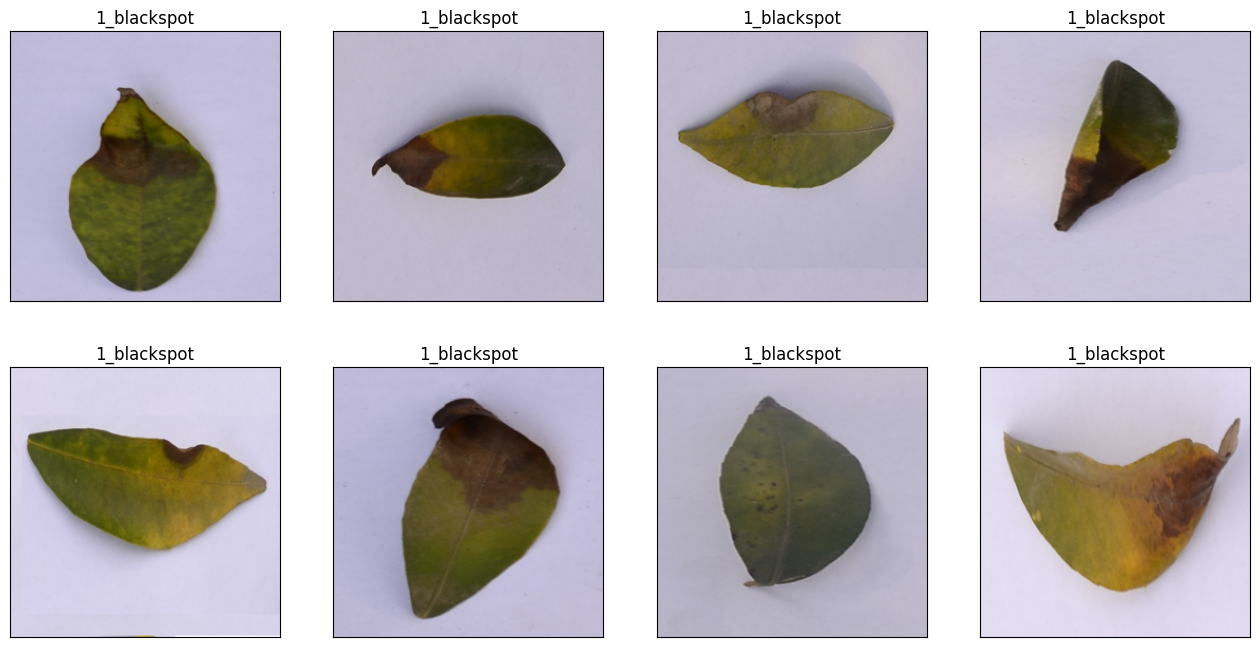

In [ ]:
visualize_batch(test_dataloader)

> Play with both data loaders (train/test) and visualize batches multiple times. See what happens, and understand why).

## 4. Define a Model (Convolutional + Fully Connected)

Now, we have a dataloader working. It will feed the input image and its real class (as [one-hot encoding](https://en.wikipedia.org/wiki/One-hot)) data to a deep learning model. In this dynamic process, we expect that, given an input image, our model will learn and adapt to classify it correctly.

Now, the following cells define our deep-learning model. It has two pieces:

- Encoder: Convolutional and Max-Pooling Layers, which extract image features.
- Decoder: Fully connected layers responsible for interpreting extracted features and classifying them into one of our five classes.

First, we import necessary libraries.

In [ ]:
import torch
from torch import nn
from tifffile import imsave

Let us first define a method to help us:

`conv`: Implements a convolutional block with ReLU and MaxPooling.

In [ ]:
def conv(
        in_channels:int,
        out_channels:int,
        kernel_size:int,
        padding:int=1
) -> torch.nn.modules.container.Sequential:
    return nn.Sequential(
        nn.Conv2d(
            in_channels, out_channels, kernel_size=kernel_size,
            stride=1, padding=padding),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=(3, 3), stride=2, padding=1)
    )

> Testing it will create a convolutional block composed of 3 `Sequential` operations: 1. a 2D Convolution; 2. a ReLU activation function; 3. a 2D Max Pooling.

In [ ]:
conv(
    in_channels=3,
    out_channels=16,
    kernel_size=3,
    padding=0
)

Sequential(
  (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU(inplace=True)
  (2): MaxPool2d(kernel_size=(3, 3), stride=2, padding=1, dilation=1, ceil_mode=False)
)

Now, the class ClassificationModel defines our architecture:

1. On the **__init__** method, we first set a random_seed to guarantee reproducibility. Then, we define our encoder blocks (conv1, conv2, and conv2) and our decoder/classifier (Fully Connected, ReLU, and Droupout);
2. Our **forward** method passes the input image through the model architecture until we get the classification. Additionally, the method `torch.flatten` converts the encoder's output to a 2D tensor (batch, N);
3. **write_activation** and **save_activations** saves activations of each network block for visual inspection;
4. **save_curves** will save the learning curves of our models at the end of our training loop (to a `model_folder`);
5. **save_model_weights** save the model weights a `model_folder`;
6. **load_best_model** loads the best-trained model (i.e., lower loss).

To initialize a Classification model, we must set the following parameters:

- `in_channels:` The number of channels of our input (e.g., 3 for RGB and 1 for Gray);
- `n_kernels:` A list of 3 integer values specifying the number of kernels for each convolutional block (e.g., [8, 16,32]).
- `kernel_sizes:` A list of 3 integer values, specifying the kernels' size for each convolutional block (e.g., [3, 3, 3]);
- `fc_neurons:` A list of 2 integers specifying the number of neurons for our 2 Fully-Connected Layers;
- `model_folder`: An output folder to save model weights and learning curves;
- `activations_path:` A path to save each convolutional block activation. After training, one could navigate into that folder to visualize the features the model extracts.

> IMPORTANT: Saving activations increases training time, so it could be turned off by not setting the activations_path or setting it as `None` (Standard Value).

In [ ]:
class ClassificationModel(nn.Module):
    def __init__(
        self, in_channels: int, # RGB or LAB -> 3 Channels
        n_kernels: List[int], # N Kernels by conv block
        kernel_sizes: List[int], # Kernel sizes by conv block
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        model_folder: PosixPath, # Path to save model weights and learning curves
        activations_path: PosixPath = None # Path to save activations
    ) -> None:
        super().__init__()
        self.activations_path = activations_path
        self.model_folder = model_folder
        os.makedirs(self.model_folder, exist_ok=True)
        self.weights_folder = model_folder / Path("weights")
        os.makedirs(self.weights_folder, exist_ok=True)

        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # Classification Encoder
        self.conv1 = conv(
            in_channels=in_channels, out_channels=n_kernels[0],
            kernel_size=kernel_sizes[0],padding=kernel_sizes[0]//2
        )
        self.conv2 = conv(
            in_channels=n_kernels[0], out_channels=n_kernels[1],
            kernel_size=kernel_sizes[1],padding=kernel_sizes[1]//2
        )
        self.conv3 = conv(
            in_channels=n_kernels[1], out_channels=n_kernels[2],
            kernel_size=kernel_sizes[2],padding=kernel_sizes[2]//2
        )

        # Classification Decoder (Classifier)
        self.classifier = nn.Sequential(
            nn.Linear(in_features=32*32*n_kernels[2], out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )

        # Initialize weights (XAVIER)
        self._initialize_weights()

    def forward(self, x):
        # List to keep track of activations
        self.activations = []

        # Extract Features
        x = self.conv1(x)
        self.activations.append(x)
        x = self.conv2(x)
        self.activations.append(x)
        x = self.conv3(x)
        self.activations.append(x)

        #Flattens input tensor into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        y = self.classifier(x)

        return y

    def _initialize_weights(self) -> None:
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                #get the number of elements in the layer weights
                n = m.kernel_size[0] * m.kernel_size[1] * m.in_channels
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = sqrt(2. / n))
                m.weight.data.normal_(mean=0, std=np.sqrt(2. / n))
                if m.bias is not None:
                    #initialize bias with 0
                    m.bias.data.zero_()
            elif isinstance(m, nn.Linear):
                #initialize layer weights with random values generated from a normal
                #distribution with mean = 0 and std = 1/100
                m.weight.data.normal_(mean=0, std=0.01)
                if m.bias is not None:
                #initialize bias with 0
                    m.bias.data.zero_()

    def write_activation(
        self, image: np.ndarray, path: PosixPath, reshape: bool=False
    ) -> None:
        max_img = np.max(image)
        min_img = np.min(image)
        if (min_img != max_img):
            image = 255 * (image - min_img) / (max_img - min_img)
        image = image.astype(np.uint8)

        image = Image.fromarray(image)
        if reshape:
            image = image.resize((256, 256), Image.Resampling.NEAREST)
        image.save(path)

    # Save encoder activations
    @torch.no_grad()
    def save_activations(
        self, epoch: int,
        data_loader: torch.utils.data.dataloader.DataLoader
    ) -> None:
        activations_path = self.activations_path / Path(f"epoch_{epoch}")

        # Saving activations for each image
        print("[INFO] Saving activations!")
        images_path = data_loader.dataset.images_path
        to_tensor = transforms.ToTensor()
        for image_path in tqdm(images_path):
            image_name = image_path.stem
            saving_path = activations_path / Path(image_name) / Path("encoder")
            saving_path_reshape = activations_path / Path(image_name) / Path("encoder_reshape")
            os.makedirs(saving_path, exist_ok=True)
            os.makedirs(saving_path_reshape, exist_ok=True)

            image_data = to_tensor(Image.open(image_path))
            # Adds Batch Dimension
            image_data = torch.unsqueeze(image_data, dim=0)
            image_data = image_data.to(DEVICE)
            self.to(DEVICE)
            self.forward(image_data)

            # Save encoder activations
            for actv_idx, activations in enumerate(self.activations):
                activations = activations.cpu().detach().numpy()
                for ch_idx in range(activations.shape[1]):
                    channel_activations = activations[0, ch_idx, ...]

                    filename = Path(f"layer_{actv_idx}_ch_{ch_idx}.png")
                    # Save normal size image
                    self.write_activation(
                        channel_activations, saving_path / filename
                    )
                    # Save with the same shape as input
                    self.write_activation(
                        channel_activations, saving_path_reshape / filename, True
                    )

        # Save model weights
        torch.save(self.state_dict(), activations_path / Path("model.pth"))

    def load_best_model(self) -> None:
        weight_files = os.listdir(self.weights_folder)
        losses = [file.split("_")[3] for file in weight_files]
        best_weight_file = weight_files[np.argmin(losses)]
        best_weight_path = self.weights_folder / Path(best_weight_file)
        self.load_state_dict(
            torch.load(best_weight_path, weights_only=True, map_location=torch.device(DEVICE))
        )

    def save_model_weights(
        self, epoch: int, loss: float, accuracy: float
    ) -> None:
        weights_path = self.weights_folder / Path(f"epoch_{epoch}_loss_{loss:.3}_{accuracy:.3}.pth")
        torch.save(
            self.state_dict(), weights_path
        )

    def save_curves(
        self, losses: List[float], accuracies: List[float]
    ) -> None:
        plt.ioff()
        epochs = [e + 1 for e in range(len(losses))]

        # Save loss curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, losses, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, losses, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Loss', fontsize=14, color='#555555')
        ax.set_title('Training Loss Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("loss.png")
        plt.savefig(savefig_path)
        plt.close()

        # Save Accuracy curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, accuracies, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, accuracies, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Accuracy', fontsize=14, color='#555555')
        ax.set_title('Accuracy Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("accuracy.png")
        plt.savefig(savefig_path)
        plt.close()

        plt.ion()

Let us now define a model and print its architecture:

In [ ]:
# If necessary install torchview
!python -m pip install torchview

In [ ]:
from torchview import draw_graph

In [ ]:
model = ClassificationModel(
    in_channels=3, n_kernels=[16, 32, 64],
    kernel_sizes=[3, 3, 3], fc_neurons=[256, 5],
    model_folder=MODEL_FOLDER,
    activations_path=None
)

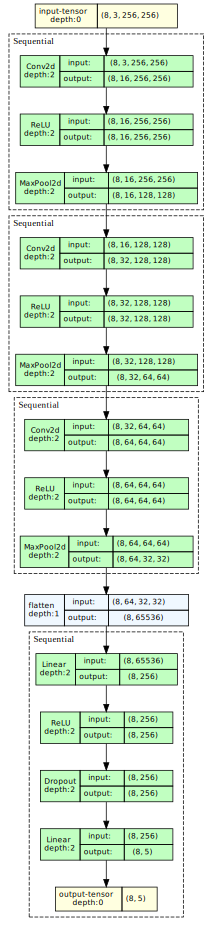

In [ ]:
model_graph = draw_graph(model, input_size=(8,3,256,256), expand_nested=True)
model_graph.visual_graph

## 5/6. Defining a training loop and training the model

We have everything prepared in our pipeline; we lack a training loop that will feed data from the data loader to our model, use the model's prediction to compute loss, and update the model's parameter.

We will also save the model's weights to use later (if the loss improves, epoch-to-epoch).

First, we import the necessary libraries:

In [ ]:
from torch import optim
from torchsummary import summary

Secondly, we define a loss function that we want to optimize. The loss function is calculated by comparing the model's predicted class with the ground-truth class mask. Optimizing the loss functions means classifying more images correctly.

We will use [Cross Entropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html). Additionally, we could set different weights for each class, which helps tackle unbalanced or problematic classes.

> See our slide decks and the link provided for further details.

Our method `criterion` computes each batch's loss and accuracy. It also implements [weight decay](https://towardsdatascience.com/this-thing-called-weight-decay-a7cd4bcfccab) and [l2 regularization](https://developers.google.com/machine-learning/crash-course/regularization-for-simplicity/l2-regularization).

In [ ]:
loss_function = nn.CrossEntropyLoss(
    weight=torch.Tensor(WEIGHT_VECTOR)
).to(DEVICE)

# Loss Function with L2 Regularization
def criterion(model, preds, targets, loss_function):
    loss_scalar = loss_function(preds, targets)

    # Add l2_regularization
    l2_regularization = 0
    for param in model.parameters():
        l2_regularization += torch.norm(param, 2)
    loss_scalar += 0.0001 * l2_regularization # 0.0001 is the weight_decay
    # Compute mean accuracy in the batch
    pred_labels = torch.max(preds, 1)[1] # same as argmax
    target_labels = torch.max(targets, 1)[1] # same as argmax
    acc = torch.sum(pred_labels == target_labels)
    n = pred_labels.size(0)
    acc = acc/n

    return loss_scalar, acc

Finally, we define our training loop. For such, we must provide:

- The number of epochs to train our model;
- Our Classification Model;
- A data loader;
- Our learning rate (lr), which controls the size of updates in the models' parameters. A too-high value will cause instability, while a too-low value will result in slower training;
- Our loss function;
- And the `n_save_activations` controls when we save our convolution activations. For instance, currently, it writes activations for every 200 epochs. However, if we set the model's `activations_path` to None, we will not save the activations.

In [ ]:
def train_loop(
    epochs, model, dataloader, lr, loss_function,
    n_save_activations=200
):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(DEVICE)
    epoch_losses = []
    epoch_accuracies = []
    for epoch in range(epochs):
        losses = []
        accuracies = []
        for batch in dataloader:
            model.train()
            image, ground_truth = batch
            image = image.to(DEVICE)
            ground_truth = ground_truth.to(DEVICE)
            prediction = model(image)
            optimizer.zero_grad()

            # Gets Loss and Accuracy
            loss, acc = criterion(model, prediction, ground_truth, loss_function)
            losses.append(loss)
            accuracies.append(acc)

            loss.backward()
            optimizer.step()

        mean_loss = torch.mean(torch.Tensor(losses))
        mean_acc = torch.mean(torch.Tensor(accuracies))

        print(f"[{epoch + 1}/{epochs}] Avg Loss: {mean_loss.item()} | Avg Accuracy: {mean_acc.item()}")

        epoch_losses.append(mean_loss.item())
        epoch_accuracies.append(mean_acc.item())

        # Each 10 epoch verifyies if the model improved
        if ((epoch + 1) % 10) == 0:
            if epoch_losses[-1] < epoch_losses[-10]:
                model.save_model_weights(
                    epoch+1, epoch_losses[-1], epoch_accuracies[-1]
                )

        if model.activations_path != None:
            if ((epoch + 1) % n_save_activations) == 0:
                model.save_activations(epoch, dataloader)

    model.save_curves(epoch_losses, epoch_accuracies)

Then, we run our training loop, using the training data loader defined before:

In [ ]:
train_loop(
    epochs=EPOCHS,
    model=model,
    dataloader=train_dataloader,
    lr=LR,
    loss_function=loss_function
)

[1/150] Avg Loss: 1.8029052019119263 | Avg Accuracy: 0.18262986838817596
[2/150] Avg Loss: 1.7497928142547607 | Avg Accuracy: 0.24512986838817596
[3/150] Avg Loss: 1.7139801979064941 | Avg Accuracy: 0.3189935088157654
[4/150] Avg Loss: 1.6551369428634644 | Avg Accuracy: 0.37905845046043396
[5/150] Avg Loss: 1.6320914030075073 | Avg Accuracy: 0.3538961112499237
[6/150] Avg Loss: 1.5806220769882202 | Avg Accuracy: 0.38230517506599426
[7/150] Avg Loss: 1.5522621870040894 | Avg Accuracy: 0.37094154953956604
[8/150] Avg Loss: 1.510043740272522 | Avg Accuracy: 0.42775973677635193
[9/150] Avg Loss: 1.5237656831741333 | Avg Accuracy: 0.38798701763153076
[10/150] Avg Loss: 1.4988181591033936 | Avg Accuracy: 0.41558438539505005
[11/150] Avg Loss: 1.461410403251648 | Avg Accuracy: 0.413149356842041
[12/150] Avg Loss: 1.4458816051483154 | Avg Accuracy: 0.4342532455921173
[13/150] Avg Loss: 1.4085279703140259 | Avg Accuracy: 0.43912336230278015
[14/150] Avg Loss: 1.3993996381759644 | Avg Accuracy: 

## 7/8. Defining a testing loop and testing our best model

Now, we can define a new model, load the best models, and assess our results on both training and test data.

First, let us load our best weights:

In [ ]:
model.load_best_model()

Then, we import the necessary libraries to assess our model.

In [ ]:
import pandas as pd
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

The cells below define a method to use our trained model and predict each image class. We also compute metrics between the predicted and the ground truth classes. The following metrics were computed:

- [Accuracy](https://torchmetrics.readthedocs.io/en/stable/classification/accuracy.html)
- [cohen kappa score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.cohen_kappa_score.html)

Additionally, we also show a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix). It is a well-known method to assess classification performance. The diagonal represents correct predictions, while other matrix elements indicate the number of images misclassified for each class (with the incorrect prediction).

Finally, a classification report also shows additional metrics, such as [precision, recall, and f1-score](https://scikit-learn.org/stable/auto_examples/model_selection/plot_precision_recall.html#precision-recall).

In [ ]:
@torch.no_grad()
def predict_and_evaluate(
    model: ClassificationModel,
    data_loader: torch.utils.data.dataloader.DataLoader,
    dataset: str="test"
) -> None:
    images_path = data_loader.dataset.images_path
    preds_path = model.model_folder / Path(f"preds_{dataset}.csv")
    model.eval()

    preds_dict = {
        "image_path": [],
        "ground_truth": [],
        "pred_label": [],
        "prediction": []
    }
    to_tensor = transforms.ToTensor()
    for image_path in tqdm(images_path):
        class_folder = os.path.dirname(image_path).split("/")[-1]
        ground_truth = int(class_folder.split("_")[0])

        image_data = to_tensor(Image.open(image_path))
        # Adds batch dimension
        image_data = torch.unsqueeze(image_data, dim=0)
        image_data = image_data.to(DEVICE)
        prediction = model(image_data).cpu().detach().numpy()[0]
        predicted_label = np.argmax(prediction) + 1

        preds_dict["image_path"].append(image_path)
        preds_dict["ground_truth"].append(ground_truth)
        preds_dict["pred_label"].append(predicted_label)
        preds_dict["prediction"].append(prediction)

    df = pd.DataFrame.from_dict(preds_dict)
    df.to_csv(preds_path, index=False)

    # Computes metrics for Multiclass Classification
    print(f"[INFO] Metrics for {dataset} dataset")
    cohen_kappa = cohen_kappa_score(preds_dict["ground_truth"], preds_dict["pred_label"])
    print(f"[INFO] Cohen Kappa Score: {cohen_kappa:.3f}")


    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
    plt.rc('font', size=9)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[0]
    )
    axs[0].set_title("Confusion matrix (CM)")
    plt.rc('font', size=10)
    ConfusionMatrixDisplay.from_predictions(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        ax=axs[1],
        normalize="true", values_format=".0%"
    )
    axs[1].set_title("CM normalized by row")
    plt.show()

    report = classification_report(
        preds_dict["ground_truth"],
        preds_dict["pred_label"],
        target_names=list(CLASSES_LIST)
    )
    print(report)

Now, we can assess our best model on both training and test data:

100%|██████████| 175/175 [00:00<00:00, 233.94it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 0.864


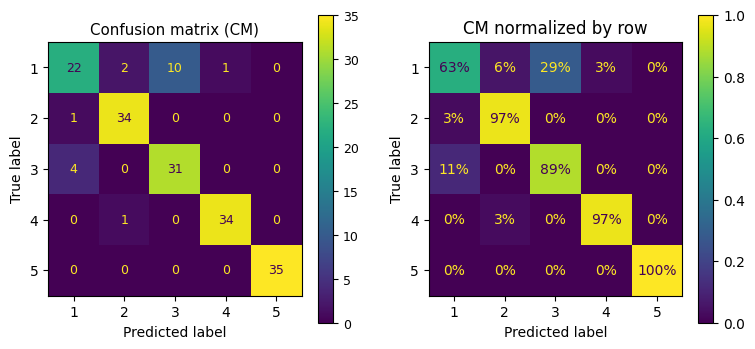

              precision    recall  f1-score   support

 1_blackspot       0.81      0.63      0.71        35
    2_canker       0.92      0.97      0.94        35
  3_greening       0.76      0.89      0.82        35
   4_healthy       0.97      0.97      0.97        35
  5_melanose       1.00      1.00      1.00        35

    accuracy                           0.89       175
   macro avg       0.89      0.89      0.89       175
weighted avg       0.89      0.89      0.89       175



In [ ]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████| 75/75 [00:00<00:00, 242.83it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.683


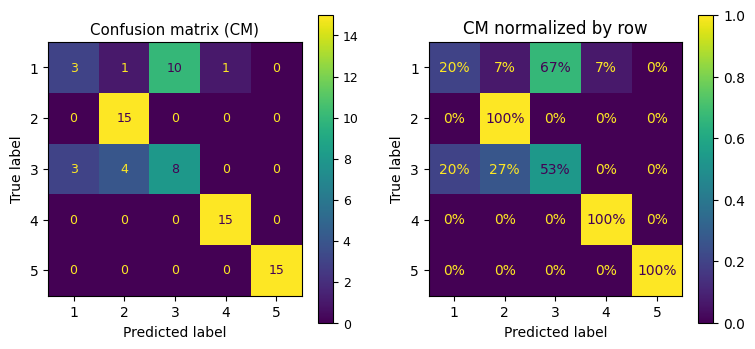

              precision    recall  f1-score   support

 1_blackspot       0.50      0.20      0.29        15
    2_canker       0.75      1.00      0.86        15
  3_greening       0.44      0.53      0.48        15
   4_healthy       0.94      1.00      0.97        15
  5_melanose       1.00      1.00      1.00        15

    accuracy                           0.75        75
   macro avg       0.73      0.75      0.72        75
weighted avg       0.73      0.75      0.72        75



In [ ]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

As we can see, even with augmentation, our model considerably overfits the training data (training Kappa > test Kappa).

Now, explore different architectures and verify the impact on the results.

> DISCLAIMER: Usually, we train our model and assess our results on a validation set. The test set is only used when we choose the best model to avoid overfitting the test data. For the sake of simplicity, we only employed training and test data.

## Bonus: Fine-tunning a VGG network

A common approach is to use pre-trained models, which were previously trained on a vast amount of data ([ImageNet](https://image-net.org), for instance), and then fine-tune to a few data points.

This example will load the VGG network, a convolutional encoder, pretrained in ImageNet. The VGG-Encoder output will be fed into our fully connected layers and classified into one of our five classes. In summary, we will load the VGG-Encoder and fine-tune it on our data (citrus leaves).

In [ ]:
MODEL_FOLDER = Path("citrus_leaves/models/vgg_sample_model")

In [ ]:
class VGGClassificationModel(nn.Module):
    def __init__(
        self,
        fc_neurons: List[int], # N Neurons for FC (Fully Connected) Layers
        model_folder: PosixPath, # Path to save model weights and learning curves
    ) -> None:
        super().__init__()
        self.activations_path = None
        self.model_folder = model_folder
        os.makedirs(self.model_folder, exist_ok=True)
        self.weights_folder = model_folder / Path("weights")
        os.makedirs(self.weights_folder, exist_ok=True)

        # Sets torch seed to guarantee Reproducibility
        random_seed = 7
        torch.manual_seed(random_seed)
        torch.cuda.manual_seed(random_seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

        # VGG Encoder
        self.vgg_model = models.vgg16(weights='IMAGENET1K_V1')
        # Specify you do not want to train the parameters of the model
        for param in model.parameters():
          param.requires_grad = False
        """ The vgg16 model consists of three modules: features, avgpool, and
        classifier. Change avgpool to return a feature map of size 1x1 instead
        of 7x7. This will create batches with 512x1x1 tensors.
        """
        self.vgg_model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))


        # Classification Decoder (Classifier)
        self.vgg_model.classifier = nn.Sequential(
            nn.Linear(in_features=512, out_features=fc_neurons[0]),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(in_features=fc_neurons[0], out_features=fc_neurons[1]),
        )

        # Initialize weights (XAVIER) # Only initializes
        self._initialize_weights()

    def forward(self, x):
        y = self.vgg_model(x)

        return y

    def _initialize_weights(self) -> None:
        for m in self.modules():
          # Only initializes Fully Connected Layers
          if isinstance(m, nn.Linear):
            #initialize layer weights with random values generated from a normal
            #distribution with mean = 0 and std = 1/100
            m.weight.data.normal_(mean=0, std=0.01)
            if m.bias is not None:
            #initialize bias with 0
                m.bias.data.zero_()

    def load_best_model(self) -> None:
        weight_files = os.listdir(self.weights_folder)
        losses = [file.split("_")[3] for file in weight_files]
        best_weight_file = weight_files[np.argmin(losses)]
        best_weight_path = self.weights_folder / Path(best_weight_file)
        self.load_state_dict(
            torch.load(best_weight_path, weights_only=True)
        )

    def save_model_weights(
        self, epoch: int, loss: float, accuracy: float
    ) -> None:
        weights_path = self.weights_folder / Path(f"epoch_{epoch}_loss_{loss:.3}_{accuracy:.3}.pth")
        torch.save(
            self.state_dict(), weights_path
        )

    def save_curves(
        self, losses: List[float], accuracies: List[float]
    ) -> None:
        plt.ioff()
        epochs = [e + 1 for e in range(len(losses))]

        # Save loss curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, losses, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, losses, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Loss', fontsize=14, color='#555555')
        ax.set_title('Training Loss Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("loss.png")
        plt.savefig(savefig_path)
        plt.close()

        # Save Accuracy curve
        fig, ax = plt.subplots(figsize=(12, 6), facecolor='#f6f6f6')
        line, = ax.plot(epochs, accuracies, color='#FF5733', linewidth=3, label='Training Loss')
        gradient_fill = ax.fill_between(epochs, accuracies, color='#FF5733', alpha=0.3)
        ax.set_xlabel('Epochs', fontsize=14, color='#555555')
        ax.set_ylabel('Accuracy', fontsize=14, color='#555555')
        ax.set_title('Accuracy Curve', fontsize=18, fontweight='bold', color='#333333')
        savefig_path = self.model_folder / Path("accuracy.png")
        plt.savefig(savefig_path)
        plt.close()

        plt.ion()

In [ ]:
model = VGGClassificationModel(
    fc_neurons=[256, 5],
    model_folder=MODEL_FOLDER
)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 80.4MB/s]


In [ ]:
train_loop(
    epochs=50,
    model=model,
    dataloader=train_dataloader,
    lr=LR,
    loss_function=loss_function
)

[1/50] Avg Loss: 1.7958470582962036 | Avg Accuracy: 0.24025973677635193
[2/50] Avg Loss: 1.7830307483673096 | Avg Accuracy: 0.39448052644729614
[3/50] Avg Loss: 1.6678390502929688 | Avg Accuracy: 0.5251623392105103
[4/50] Avg Loss: 1.1986147165298462 | Avg Accuracy: 0.5941558480262756
[5/50] Avg Loss: 0.9325750470161438 | Avg Accuracy: 0.6347402930259705
[6/50] Avg Loss: 0.7608577609062195 | Avg Accuracy: 0.7589285373687744
[7/50] Avg Loss: 0.7262025475502014 | Avg Accuracy: 0.7191558480262756
[8/50] Avg Loss: 0.5732710957527161 | Avg Accuracy: 0.7946428656578064
[9/50] Avg Loss: 0.5213653445243835 | Avg Accuracy: 0.8011363744735718
[10/50] Avg Loss: 0.4715742766857147 | Avg Accuracy: 0.8108766674995422
[11/50] Avg Loss: 0.48074591159820557 | Avg Accuracy: 0.8116883635520935
[12/50] Avg Loss: 0.44885575771331787 | Avg Accuracy: 0.8116883635520935
[13/50] Avg Loss: 0.41239821910858154 | Avg Accuracy: 0.8238636255264282
[14/50] Avg Loss: 0.40014421939849854 | Avg Accuracy: 0.822240293025

In [ ]:
model.load_best_model()

100%|██████████| 175/175 [00:01<00:00, 92.82it/s]


[INFO] Metrics for train dataset
[INFO] Cohen Kappa Score: 0.850


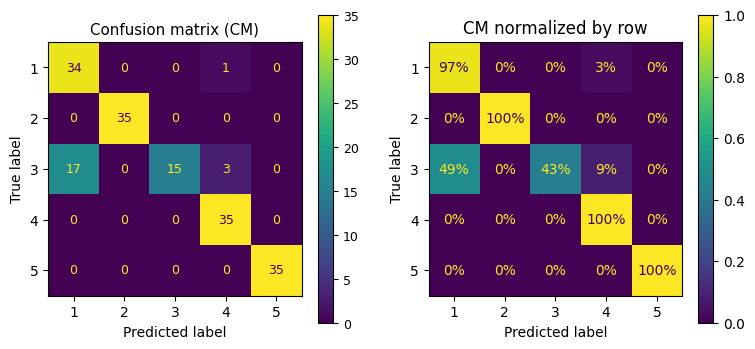

              precision    recall  f1-score   support

 1_blackspot       0.67      0.97      0.79        35
    2_canker       1.00      1.00      1.00        35
  3_greening       1.00      0.43      0.60        35
   4_healthy       0.90      1.00      0.95        35
  5_melanose       1.00      1.00      1.00        35

    accuracy                           0.88       175
   macro avg       0.91      0.88      0.87       175
weighted avg       0.91      0.88      0.87       175



In [ ]:
predict_and_evaluate(
    model=model,
    data_loader=train_dataloader,
    dataset="train"
)

100%|██████████| 75/75 [00:00<00:00, 93.84it/s]


[INFO] Metrics for test dataset
[INFO] Cohen Kappa Score: 0.900


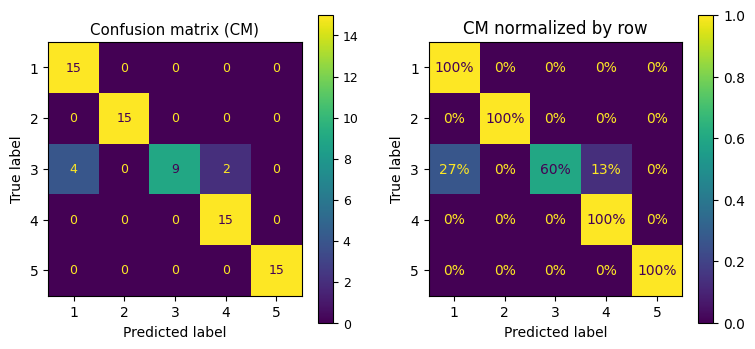

              precision    recall  f1-score   support

 1_blackspot       0.79      1.00      0.88        15
    2_canker       1.00      1.00      1.00        15
  3_greening       1.00      0.60      0.75        15
   4_healthy       0.88      1.00      0.94        15
  5_melanose       1.00      1.00      1.00        15

    accuracy                           0.92        75
   macro avg       0.93      0.92      0.91        75
weighted avg       0.93      0.92      0.91        75



In [ ]:
predict_and_evaluate(
    model=model,
    data_loader=test_dataloader,
    dataset="test"
)

# Extra - Activities

- Try different classes weights (cross entropy loss) and verify if you can improve model's performance for all classes
- Modify augmentations and verify if you improve model's generalization
- Test different configurations for your model (e.g., number of filters, filters size, number of neurons for the hidden layer) and verify if you can improve model's performance
- Verify if you can improve separability of classes on the projections (Classifiers) [TODO] Move it to the notebook 3.